# Loading Data

In [2]:
import pandas as pd

In [8]:
data = pd.read_csv('./Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [11]:
print(train_df.shape)
print(test_df.shape)

(1472952, 16)
(23634, 16)


In [12]:
data

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,8ca9f102-02a4-4207-ab63-484e83a1bdf0,42.32,2024-03-24 23:42:43,PayPal,electronics,1,40,East Jameshaven,desktop,110.87.246.85,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,0,282,23
1,7d187603-7961-4fce-9827-9698e2b6a201,4d158416-caae-4b09-bd5b-15235deb9129,301.34,2024-01-22 00:53:31,credit card,electronics,3,35,Kingstad,tablet,14.73.104.153,"5230 Stephanie Forge\nCollinsbury, PR 81853","5230 Stephanie Forge\nCollinsbury, PR 81853",0,223,0
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,ccae47b8-75c7-4f5a-aa9e-957deced2137,340.32,2024-01-22 08:06:03,debit card,toys & games,5,29,North Ryan,desktop,67.58.94.93,"195 Cole Oval\nPort Larry, IA 58422","4772 David Stravenue Apt. 447\nVelasquezside, ...",0,360,8
3,e9949bfa-194d-486b-84da-9565fca9e5ce,b04960c0-aeee-4907-b1cd-4819016adcef,95.77,2024-01-16 20:34:53,credit card,electronics,5,45,Kaylaville,mobile,202.122.126.216,"7609 Cynthia Square\nWest Brenda, NV 23016","7609 Cynthia Square\nWest Brenda, NV 23016",0,325,20
4,7362837c-7538-434e-8731-0df713f5f26d,de9d6351-b3a7-4bc7-9a55-8f013eb66928,77.45,2024-01-16 15:47:23,credit card,clothing,5,42,North Edwardborough,desktop,96.77.232.76,"2494 Robert Ramp Suite 313\nRobinsonport, AS 5...","2494 Robert Ramp Suite 313\nRobinsonport, AS 5...",0,116,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23629,d8b7171f-bdd9-479c-b98b-396c621aebfe,98a3d94c-dc9a-4525-b273-e6ffe54cc5a4,53.73,2024-01-26 16:25:05,PayPal,toys & games,5,32,Rebeccafurt,tablet,173.97.197.128,USNV Clayton\nFPO AE 82639,USNV Clayton\nFPO AE 82639,0,363,16
23630,0fd12cf3-c641-4499-8de1-15dc4555cb0c,b3429f52-8b27-46b5-914c-4accd989edb4,47.42,2024-02-25 17:03:26,credit card,clothing,4,41,Nataliefort,desktop,133.222.22.48,"9288 Patricia Cape Apt. 527\nMelissaton, IL 38543","9288 Patricia Cape Apt. 527\nMelissaton, IL 38543",0,296,17
23631,649680d3-a684-44cb-95bf-9b454c3aa86d,066e25c9-4420-4224-bc3f-1a462708090e,1045.23,2024-03-28 23:46:47,bank transfer,health & beauty,1,9,East Shannonville,tablet,206.133.237.168,3015 Elizabeth Summit Suite 819\nEast Joelfort...,3015 Elizabeth Summit Suite 819\nEast Joelfort...,0,329,23
23632,c10dbb08-28fc-4ec1-9850-d4e98d2b9640,cde96e9c-f562-4b8c-8fa8-f356f474232b,34.25,2024-02-09 11:29:18,debit card,home & garden,2,39,Lake Nicole,mobile,16.204.137.130,"531 Brittany Pike\nNew Stacy, OR 87952","531 Brittany Pike\nNew Stacy, OR 87952",0,347,11


In [10]:
train_df.head()

(23634, 16)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction ID      23634 non-null  object 
 1   Customer ID         23634 non-null  object 
 2   Transaction Amount  23634 non-null  float64
 3   Transaction Date    23634 non-null  object 
 4   Payment Method      23634 non-null  object 
 5   Product Category    23634 non-null  object 
 6   Quantity            23634 non-null  int64  
 7   Customer Age        23634 non-null  int64  
 8   Customer Location   23634 non-null  object 
 9   Device Used         23634 non-null  object 
 10  IP Address          23634 non-null  object 
 11  Shipping Address    23634 non-null  object 
 12  Billing Address     23634 non-null  object 
 13  Is Fraudulent       23634 non-null  int64  
 14  Account Age Days    23634 non-null  int64  
 15  Transaction Hour    23634 non-null  int64  
dtypes: f

In [12]:
data.describe()

,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000
mean,229.367099,3.000550,34.560210,0.051705,178.660531,11.266015
std,282.046669,1.419663,10.009471,0.221436,107.388682,6.980659
min,10.000000,1.000000,-2.000000,0.000000,1.000000,0.000000
25%,69.070000,2.000000,28.000000,0.000000,84.000000,5.000000
50%,151.415000,3.000000,35.000000,0.000000,178.000000,11.000000
75%,296.127500,4.000000,41.000000,0.000000,272.000000,17.000000
max,9716.500000,5.000000,73.000000,1.000000,365.000000,23.000000


# Exploratory Data Analysis

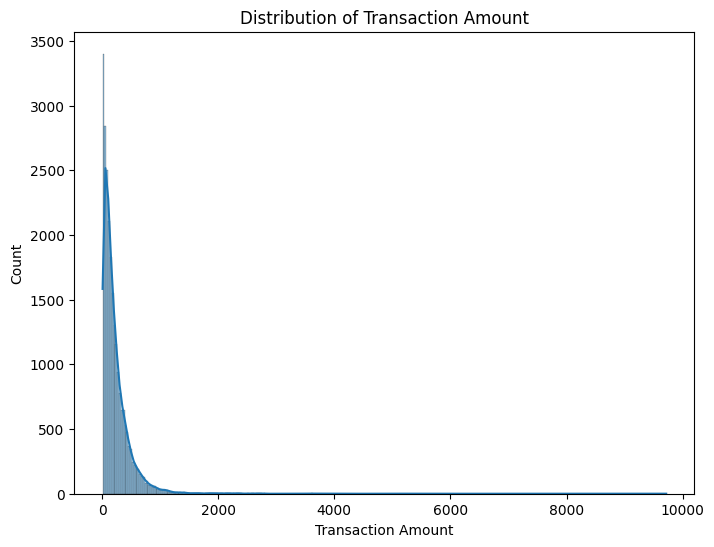

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data['Transaction Amount'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amount')
plt.show()

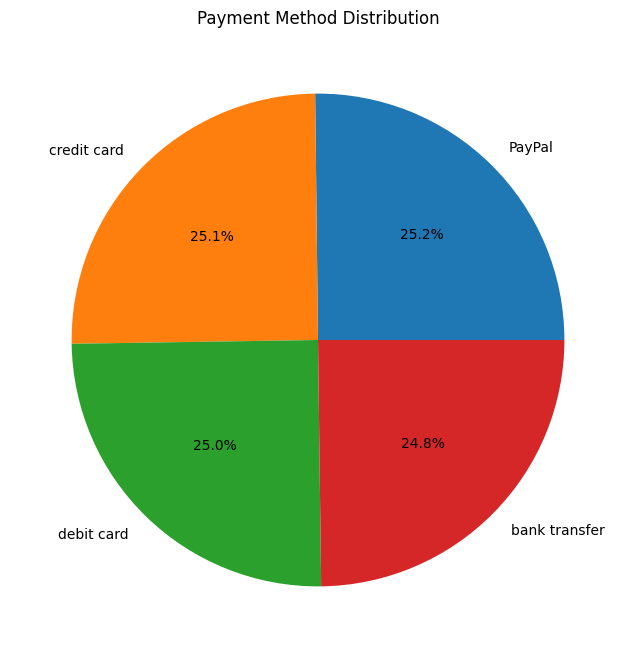

In [17]:
plt.figure(figsize=(8, 8))
plt.pie(data['Payment Method'].value_counts(), labels=data['Payment Method'].unique(), autopct='%1.1f%%')
plt.title('Payment Method Distribution')
plt.show()

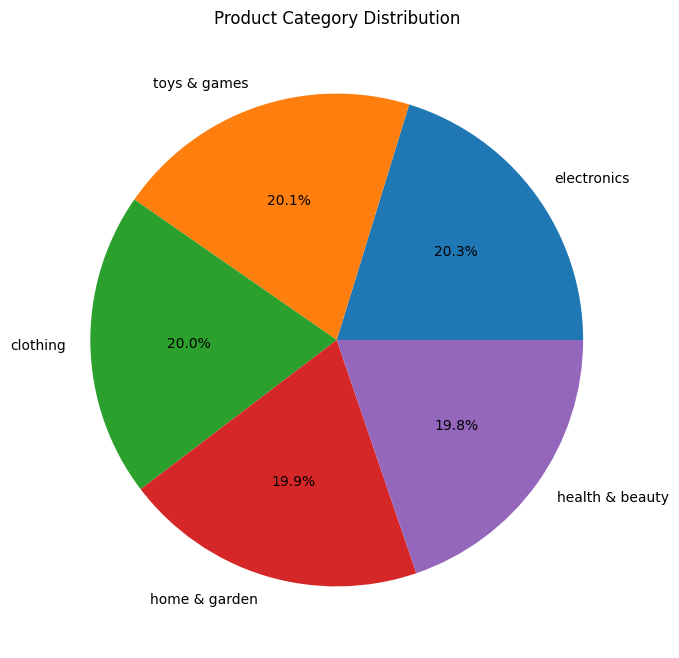

In [20]:
plt.figure(figsize=(8, 8))
plt.pie(data['Product Category'].value_counts(), labels=data['Product Category'].unique(), autopct='%1.1f%%')
plt.title('Product Category Distribution')
plt.show()

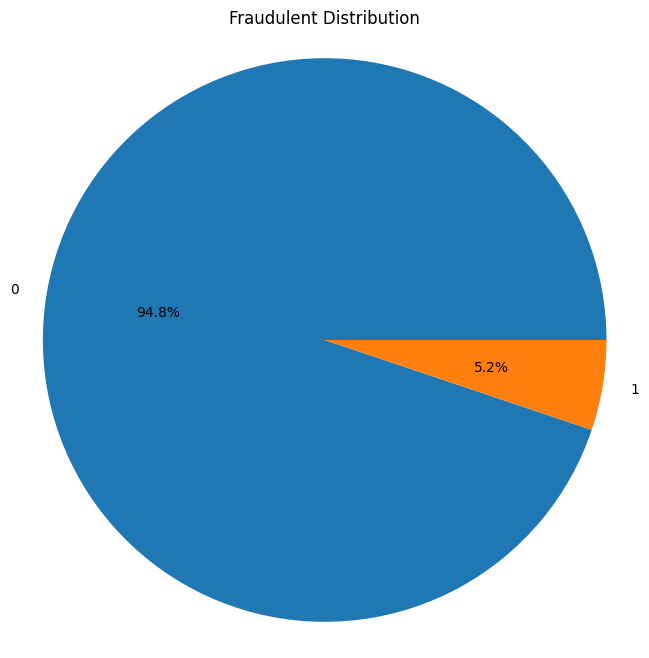

In [22]:
plt.figure(figsize=(8, 8))
plt.pie(data['Is Fraudulent'].value_counts(), labels=data['Is Fraudulent'].unique(), autopct='%1.1f%%')
plt.title('Fraudulent Distribution')
plt.axis('equal')
plt.show()

Insight: Heavy Imbalance

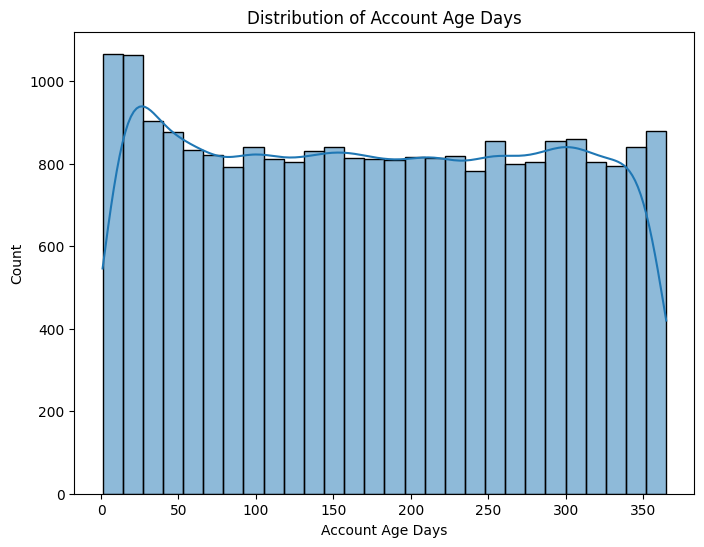

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(data['Account Age Days'], kde=True)
plt.xlabel('Account Age Days')
plt.ylabel('Count')
plt.title('Distribution of Account Age Days')
plt.show()

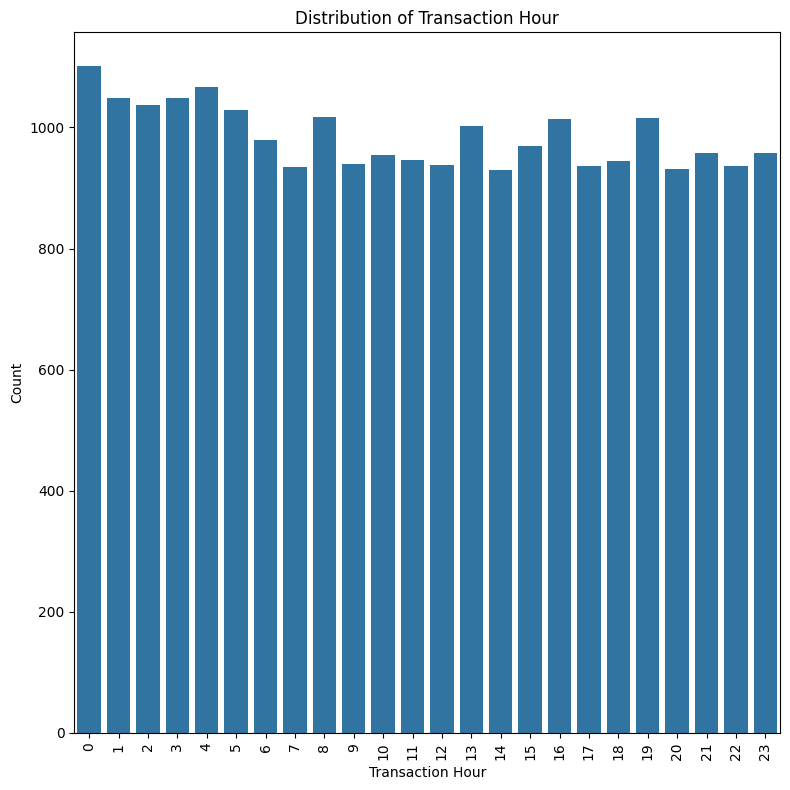

In [27]:
plt.figure(figsize=(8, 8))
sns.countplot(x='Transaction Hour', data=data)
plt.xlabel('Transaction Hour')
plt.ylabel('Count')
plt.title('Distribution of Transaction Hour')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()